# 📌 Intro: The machine learning workflow

*Taken from MachineLearningForMaterialScience.ipynb from Sherif Abdulkader Tawfik Abbas*

So how is this all done? Generally, we can think of machine learning as a 3-step process:
- Step A: First, find numerical/categoricall **descriptors** that can describe your material. That is: every material in your dataset should be uniquely represented by an array of numbers/categories.
- Step B: Then, apply your procedure to your entire dataset of structures to form a sheet of material descriptors vs. **target properties**.
- Step C: Use machine learning to predict the target properties based on the descriptors.



---



# 📌 ML as a Tool for QSPR

In materials science, Machine Learning (ML) and Quantitative Structure-Property Relationships (QSPR) are closely related, as both aim to predict material properties based on their structure or composition.

ML algorithms (e.g., neural networks, decision trees, or support vector machines) improve QSPR models by learning patterns from high-dimensional data, increasing prediction accuracy, and reducing the need for manual descriptor engineering.



---



# 📌 About this tutorial

In this tutorial, you will find an **example for linear regression** using Scikit-learn and LazyPredict.

- Scikit-learn is a popular, open-source machine learning library in Python that provides simple and efficient tools for data mining, data analysis, and machine learning. It is built on top of core Python libraries like NumPy, SciPy, and matplotlib, making it easy to integrate into scientific computing workflows.

- LazyPredict is a Python library that simplifies the process of evaluating multiple machine learning models on your dataset. Its primary goal is to quickly provide a comparative performance analysis of several machine learning algorithms without requiring extensive code or hyperparameter tuning.--> https://lazypredict.readthedocs.io/en/latest/

- The dataset used in this practice is the the preprocessed CSD_EES_DB dataset
- Machine Learning Model: Linear Regression

*Extra example*
- **Another useful example** from Prof. Gashaw M. Goshu(of a non-linear model based on decision trees and gradient boosting) in GitHub: https://github.com/gashawmg/RDKit-descriptors-for-HOMO-LUMO-energy-gap-prediction/blob/main/HOMO-LUMO%20Energy%20Gap%20Prediction%20using%20Molecular%20descriptors.ipynb

## ⚠️ Some output cells have been cleared to reduce memory usage and facilitate pushing to GitHub.

In [ ]:
print('Hello from my first ML model')

Hello from my first ML model


# Mount Drive

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Modules

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Show all the columns of the dataframe
pd.set_option('display.max_columns', None)

# Show all the rows of the dataframe
pd.set_option('display.max_rows', None)

# Packages

In [ ]:
!pip install rdkit==2024.09.4 # RDKit in EDA was rdkit-2024.9.4 so we shall install the same version
!pip install lazypredict

# Data

In [4]:
# Load the pre-processed dataset (the one from the EDA)
# Path to dataset (change the path according to your Google Drive folders)
file_path = '/content/drive/Shared drives/your_path_to_the_CSD_EES_DB_with_200_descriptors.csv'

In [ ]:
# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)
data.head(10)

In [7]:
# Drop the 'Unnamed: 0' column
data.drop(columns=['Unnamed: 0'], inplace=True)

In [9]:
# Drop the 'Unnamed: 0.1' column
data.drop(columns=['Unnamed: 0.1'], inplace=True)

In [ ]:
data.head()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19695 entries, 0 to 19694
Columns: 234 entries, ID to fr_urea
dtypes: float64(229), object(5)
memory usage: 35.2+ MB


In [ ]:
# Check if there are nan(s) in data
data.isna().sum() # <-- lots of NaN (about 297 in different columns)

In [14]:
# Check for NaN in all the df
print("NaN values:", data.isna().sum().sum())

# Make a copy of data
df = data.copy()

# Drop the rows with NaN
df = df.dropna()

# Check the len of the data
print(len(df)) # Previously, we had 47360

NaN values: 71245
17084


In [15]:
df.columns

Index(['ID', 'doi', 'formula', 'NAts', 'SMILES', 'HOMO', 'LUMO', 'E(S1)',
       'f(S1)', 'E(S2)',
       ...
       'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene',
       'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene',
       'fr_unbrch_alkane', 'fr_urea'],
      dtype='object', length=234)

## Band gap


In [16]:
# We can predict HOMO and LUMO separately and then subtract HOMO from LUMO (LUMO-HUMO) for each data point to get the Band Gap.
# But we can also first do the substraction and predict the Band Gap.
# In this example, I will opt for the second option (predict the band gap)

df['band_gap'] = df['LUMO'] - df['HOMO']


# Drop the cols LUMO and HOMO
df.drop(columns=['LUMO', 'HOMO'], inplace=True)

In [ ]:
# View the df
df.head(4)

In [18]:
# Optional

# Save df as csv
dir_path = 'your_dir_path'
df.to_csv(f'{dir_path}CSD_EES_DB_with_200_descriptors_band_gap.csv')

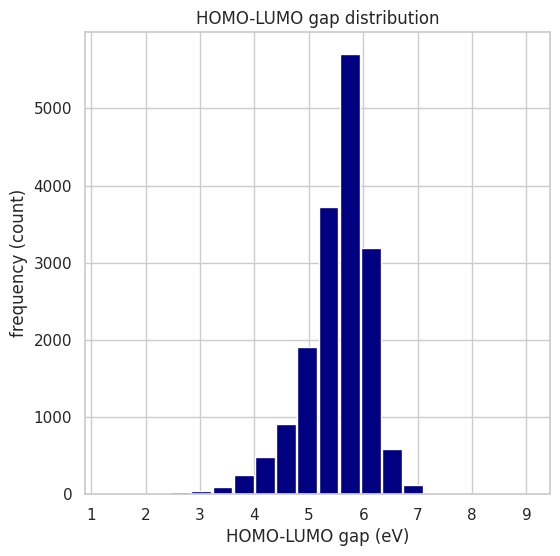

In [19]:
# Show band gap distribution

# Show the grid
sns.set_theme(style="whitegrid")

# Make plot
plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(df['band_gap'], bins= 20, rwidth=0.93, color='navy')
ax.set_title('HOMO-LUMO gap distribution')
ax.set_xlabel('HOMO-LUMO gap (eV)')
ax.set_ylabel('frequency (count)')
plt.show()

<Axes: ylabel='band_gap'>

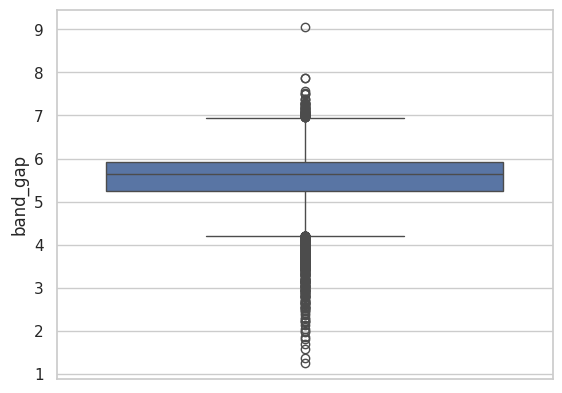

In [20]:
# Check outliers
import seaborn as sn

sn.boxplot(df.band_gap)

In [21]:
# Check other stats
df.band_gap.describe()

,band_gap
count,17084.000000
mean,5.526678
std,0.613213
min,1.266690
25%,5.238396
50%,5.638607
75%,5.924191
max,9.064657


# Remove highly correlated features

In [22]:
# Select the columns on which correlatioin will be perform (all the descriptor columns + initial columns but not the target column)
numerical_cols = df.select_dtypes(include=['number']).columns

# Drop the target column from the list of numerical cols
numerical_cols = numerical_cols.drop(['band_gap'])
print(numerical_cols)
print(len(numerical_cols))

Index(['NAts', 'E(S1)', 'f(S1)', 'E(S2)', 'f(S2)', 'E(S3)', 'f(S3)', 'E(T1)',
       'E(T2)', 'E(T3)',
       ...
       'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene',
       'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene',
       'fr_unbrch_alkane', 'fr_urea'],
      dtype='object', length=227)
227


In [ ]:
df[numerical_cols].head(3)

In [ ]:
# Run the correlation analysis previously ran in the EDA

# Correlation among te numerical columns in merge_df
corr2 = df[numerical_cols].corr()

plt.figure(figsize=(150, 80), dpi=100)
sns.set(style='white')
heatmap = sns.heatmap(corr2, annot=False, fmt='.2f', cmap='coolwarm', linewidths=0.5, linecolor='white', cbar_kws={"shrink": .8})

cbar = heatmap.collections[0].colorbar
cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
cbar.set_ticklabels(['-1', '-0.5', '0', '0.5', '1'])
cbar.ax.tick_params(labelsize=12)

plt.title('Correlation Heatmap', fontsize=12, fontweight='bold', pad=20)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12, rotation=0)
plt.show()

In [25]:
# Create a function that removes the highly correlated features

def remove_correlated_features(descriptors):
    # Calculate correlation
    correlated_matrix = descriptors.corr().abs()

    # Upper triangle of correlation matrix
    upper_triangle = correlated_matrix.where(np.triu(np.ones(correlated_matrix.shape),k=1).astype(bool))

    # Identify columns that have above 0.9 values of correlation
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] >= 0.9)]
    print(to_drop)
    descriptors_correlated_dropped = descriptors.drop(columns=to_drop, axis=1)
    return descriptors_correlated_dropped

In [ ]:
# Run the function
descriptors_correlated_dropped = remove_correlated_features(df[numerical_cols])
descriptors_correlated_dropped.head()

In [27]:
# Check how many columns were left (initally there were 229)
descriptors_correlated_dropped.shape

(17084, 185)

# Remove features (descriptors) with low variance

In [ ]:
# First, check variance of each feature
print(descriptors_correlated_dropped.var())

In [29]:
# credit to dataprofessor
# adapted from: https://github.com/dataprofessor/padel/blob/main/padelpy.ipynb

from sklearn.feature_selection import VarianceThreshold

# Function to remove features with low variance
def remove_low_variance(input_data, threshold=0.1):
    # Ensure all values have up to 5 decimals
    input_data = input_data.round(5)

    # Cap extremely large values (e.g., above 1e6) to prevent overflow
    input_data = input_data.clip(upper=1e6)

    # Apply VarianceThreshold
    selection = VarianceThreshold(threshold) # VarianceThreshold calculates the variance of each column (feature) in the input DataFrame.
    selection.fit(input_data)

    # Return the filtered DataFrame with selected features
    return input_data[input_data.columns[selection.get_support(indices=True)]]

In [30]:
# Check the shapes of the df(s) with the descriptors and the target
print(descriptors_correlated_dropped.shape) # only descriptors
print(df.shape) # descriptors + target

(17084, 185)
(17084, 233)


In [ ]:
# Run the function
low_variance_dropped = remove_low_variance(descriptors_correlated_dropped, threshold=0.1)
low_variance_dropped.head()

In [32]:
low_variance_dropped.shape # new df with descriptors

(17084, 118)

In [ ]:
# Check the minimum and maximum values of each column
min_values = low_variance_dropped.min()
max_values = low_variance_dropped.max()

# Display the results
print("Minimum values:\n", min_values)
print("\nMaximum values:\n", max_values)

# Define X and Y

In [34]:
# Quickly check the shapes of the dataframes that we have until now.
print(low_variance_dropped.shape)
print(df.shape)
print(data.shape) # More rows bc it was before removing the nans

(17084, 118)
(17084, 233)
(19695, 234)


In [ ]:
low_variance_dropped.head()

In [ ]:
# Drop the cols NAts, E(S1), f(S1), E(S2), E(S3), E(T1), E(T2),	E(T3) because we won't have these columns in Pae's data
features_df = low_variance_dropped.copy()
features_df.drop(columns=['NAts', 'E(S1)', 'f(S1)', 'E(S2)', 'E(S3)', 'E(T1)', 'E(T2)', 'E(T3)'], inplace=True)
features_df.head() # df with only RDKit features

In [37]:
# Save the list of features for later
import pickle

features_ls = features_df.columns.to_list()

dir_path = 'your_dir_path'

# Save features_ls as a pickle file
with open(f"{dir_path}features_ls.pkl", "wb") as f:
    pickle.dump(features_ls, f)

In [38]:
# Finally, assign Features and Labels
X = features_df # molecular features (rdkit features only)
y = df.band_gap # labels or target

# Train-test data split

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Use LazyPredict

In [ ]:
# Reference: https://medium.com/omics-diary/how-to-use-the-lazy-predict-library-to-select-the-best-machine-learning-model-65378bf4568e

In [ ]:
!pip install dask[dataframe] # A requirement to run LazyPredict

In [41]:
# Use Sklearn ML models in 2 lines of codes
# 42 regression ML models. Full list is here https://lazypredict.readthedocs.io/en/latest/usage.html

import lazypredict
from lazypredict.Supervised import LazyRegressor

# Specify 5 regression models because we run out of RAM memory if we try the 42 models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

selected_models=[LinearRegression, Ridge, Lasso, DecisionTreeRegressor, RandomForestRegressor]

# Use LazyRegressor with the selected models
regressor = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None, regressors=selected_models)
models, predictions = regressor.fit(X_train, X_test, y_train, y_test)

# Display the results
print(models.head(5))

100%|██████████| 5/5 [03:02<00:00, 36.58s/it]

                       Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                 
Lasso                               -0.03      -0.00  0.61        0.36
LinearRegression                    -0.04      -0.01  0.61        1.34
Ridge                               -0.04      -0.01  0.61        0.66
RandomForestRegressor               -0.09      -0.05  0.62      173.25
DecisionTreeRegressor               -1.26      -1.19  0.90        7.29


In [42]:
predictions

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lasso,-0.03,-0.00,0.61,0.36
LinearRegression,-0.04,-0.01,0.61,1.34
Ridge,-0.04,-0.01,0.61,0.66
RandomForestRegressor,-0.09,-0.05,0.62,173.25
DecisionTreeRegressor,-1.26,-1.19,0.90,7.29


In [43]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lasso,-0.03,-0.00,0.61,0.36
LinearRegression,-0.04,-0.01,0.61,1.34
Ridge,-0.04,-0.01,0.61,0.66
RandomForestRegressor,-0.09,-0.05,0.62,173.25
DecisionTreeRegressor,-1.26,-1.19,0.90,7.29


# Plot predicted vs true

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

X = features_df  # Features
y = df['band_gap']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [45]:
# Initialize and train the LinearRegression model
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [46]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R²: {r2}") # Yes, the model and R^2 are very bad but these are results for rdkit descriptors. Later, we can compare the performance of models with different descriptors to find the best ones.
print(f"Mean Squared Error (MSE): {mse}")


R²: -0.010529697666855187
Mean Squared Error (MSE): 0.3740879890514667


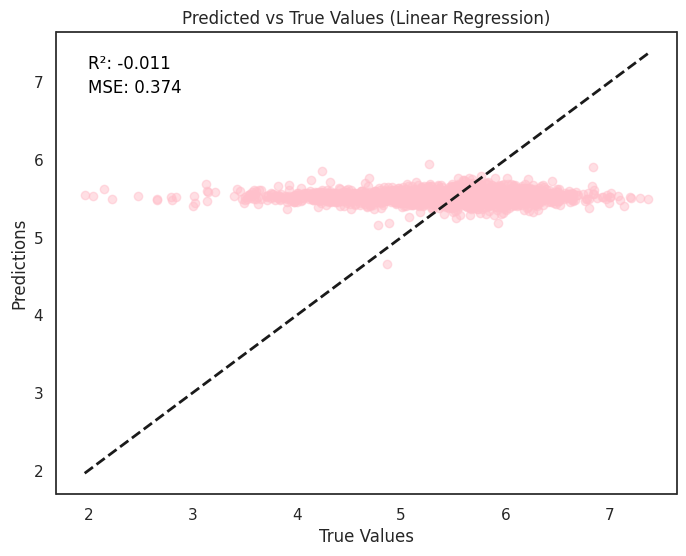

In [47]:
# Plotting Predicted vs True Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='pink', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Ideal line


# Annotate the plot with R² and MSE
plt.text(0.05, 0.95, f"R²: {r2:.3f}", ha='left', va='top', transform=plt.gca().transAxes, fontsize=12, color='black')
plt.text(0.05, 0.90, f"MSE: {mse:.3f}", ha='left', va='top', transform=plt.gca().transAxes, fontsize=12, color='black')

# Add labels and title
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predicted vs True Values (Linear Regression)')

plt.show()


# Save the model

In [48]:
dir_path = '/content/drive/Shared drives_your_dir_path' # Change to your path

In [49]:
import pickle

# Save the trained model using pickle
with open(f'{dir_path}linear_regression_model_elisa.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Linear Regression model saved!")

Linear Regression model saved!


# 🛑 Next tutorial contents (QSPR_example02)

# Load the model and predict on new data

In [50]:
# Load the model from the pickle file
with open(f'{dir_path}linear_regression_model_elisa.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Use the loaded model
y_pred = loaded_model.predict(X_test)
print("Predictions using the loaded model:", y_pred)


Predictions using the loaded model: [5.51612522 5.47401111 5.50432311 ... 5.52656669 5.51729903 5.48653809]


In [51]:
len(y_pred)

3417

In [52]:
# Compare y_test true values and y_pred in a df

# Create a DataFrame to compare true and predicted values
comparison_df = pd.DataFrame({
    'True Values': y_test,
    'Predicted Values': y_pred
})

# Display the comparison DataFrame
print(len(comparison_df))
print(comparison_df.head())

3417
       True Values  Predicted Values
12836         5.41              5.52
2643          5.52              5.47
5569          4.42              5.50
13267         5.88              5.48
6731          5.61              5.49
